<a href="https://colab.research.google.com/github/shashank3110/Master_Thesis_BA_DeepVis/blob/master/colab_notebooks/tf_sal_maps_gcam_short.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [247]:
!git clone https://github.com/LLNL/fastcam.git

!pip install pytorch_gradcam

Cloning into 'fastcam'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 553 (delta 89), reused 108 (delta 62), pack-reused 414
Receiving objects: 100% (553/553), 18.13 MiB | 28.04 MiB/s, done.
Resolving deltas: 100% (329/329), done.


In [2]:
# -*- coding: utf-8 -*-
%cd fastcam





import warnings
import os
import argparse

import tensorflow as tf
import math
import numpy as np
import torch
import torchvision
import torch.utils.data
from torch.utils.data import DataLoader,TensorDataset
import logging
from keras.layers import Input
from keras.layers.merge import concatenate
import torch.nn as nn
from torch.nn import BatchNorm3d,Conv3d,ReLU,MaxPool3d,Linear,AdaptiveAvgPool3d,Flatten,Softmax
import torch.nn.functional as F

from datetime import datetime
from torch.utils import data
import time


import skimage.io as sio
import os
import shutil
import pandas as pd
from random import shuffle

from skimage.transform import resize
import skimage.io as sio
from scipy.io import savemat,loadmat
import cv2

import mask
import draw
import norm
import misc

from torchvision import models

from random import shuffle
from torchvision.utils import make_grid, save_image

import pandas as pd
from gradcam.utils import visualize_cam
from gradcam import GradCAMpp, GradCAM
from matplotlib import pyplot as plt
"""#**Read Nii images code**"""

import os


def get_smoe_map(x,relu=True):
  print(f' smoe input shape={x.shape}')
  if relu:
    x=tf.nn.relu(x).numpy()
  print(f'x range={np.amax(x),np.amin(x)}')
  
  m   = np.mean(x,axis=-1)+0.0000001 #avoid log 0
  
  x   = x + 0.0000001
  k   = np.log2(m) - np.mean(np.log2(x), axis=-1)
  
  # k   = np.log10(m) - np.mean(np.log10(x), axis=-1)
  print(np.array_equal(np.zeros(k.shape),k))
  print(f'smoe map={k}')
  print(f'mean={m}')
  th  = k * m
  print(f'smoe output shape={th.shape}')
  return th

def get_std_map(x):
  print(f'before std map shape ={x.shape}')
  m = np.std(x,axis=-1)

  print(f'std map shape ={m.shape}')

  return m

def get_norm(x,const_mean=None,const_std=None):
  # print(f'x shape={x.shape}')
  s0      = x.shape[0]
  s1      = x.shape[1]
  s2      = x.shape[2]
  # s3      = x.shape[3]
  # print(s0,s1,s2)
  x       = np.reshape(x,(s0,s1*s2))
  # x       = np.reshape(x,(s0,s1*s2*s3))
  # print(x)
  '''
      Compute Mean
  '''
  if const_mean is None:
      m       = np.mean(x,axis=-1)
      m       = np.reshape(m,(m.shape[0],1))
  else:
      m       = const_mean
      
  '''
      Compute Standard Deviation
  '''
  if const_std is None:
      s       = np.std(x,axis=-1)
      s       = np.reshape(s,(s.shape[0],1))
  else:
      s       = const_std
  
  '''
      The normal cumulative distribution function is used to squash the values from within the range of 0 to 1
  '''
  # print(s)
  s=torch.tensor(s)
  x       = 0.5*(1.0 + torch.erf((x-m)/(s*torch.sqrt(torch.tensor(2.0)))))
          
  x       = x.reshape(s0,s1,s2)
  # x       = x.reshape(s0,s1,s2,s3)
  
  return x
  # return torch.mean(x,dim=-1)

def combine_sal_maps(smaps,output_size,weights,map_num,resize_mode='bilinear',do_relu=False):
  bn  = smaps[0].shape[0]
  cm  = torch.zeros((bn, 1, output_size[0], output_size[1]), dtype=smaps[0].dtype, device=smaps[0].device)
  ww  = []
  
  '''
      Now get each saliency map and resize it. Then store it and also create a combined saliency map.
  '''
  for i in range(len(smaps)):
      # assert torch.is_tensor(smaps[i]), "Each saliency map must be a Torch Tensor."
      wsz = smaps[i].shape
      w   = np.reshape(smaps[i],(wsz[0], 1, wsz[1], wsz[2]))#smaps[i].reshape(wsz[0], 1, wsz[1], wsz[2])
      # w=torch.from_numpy(w)
      # print(type(w))
      w   = nn.functional.interpolate(w, size=output_size, mode=resize_mode, align_corners=False) 
      ww.append(w)        # should we weight the raw maps ... hmmm
      
      cm  += (w * weights[i])

  '''
      Finish the combined saliency map to make it a weighted average.
  '''
  weight_sum =sum(weights)
  cm  = cm / weight_sum
  cm  = cm.reshape(bn, output_size[0],output_size[1])
  
  ww  = torch.stack(ww,dim=1)
  ww  = ww.reshape(bn, map_num, output_size[0], output_size[1])
  
  # if do_relu:
  #     cm = F.relu(cm)
  #     ww = F.relu(ww)
  
  return cm, ww

def compute_saliency_tf(base_path,inputs,tf_model,layer_end):

  gender=inputs[1]
  gender=tf.reshape(gender,[1,1])
  img=inputs[0]
  img_chunk=tf.convert_to_tensor(img)
  print(img_chunk.shape)
  img_chunk = tf.reshape(img_chunk,[1,121,145,6])
  layers=[layer.name for layer in tf_model.layers]
  outputs=[]
  for l in layers:
    # if l in ['activation','activation_2','activation_1']:
    if l.startswith('activation'):
    # if l.startswith('batch_normalization') or l in ['conv3d_48','conv3d_49','conv3d_50','conv3d_63',\
    # 
        outputs.append(tf_model.get_layer(name=l).output) 
  outputs.append(tf_model.output)                                         
  test_tf_model=tf.keras.models.Model([tf_model.inputs], outputs)
  # test_tf_model=tf.keras.models.Model([tf_model.inputs], [tf_model.get_layer(name=layers[2]).output,tf_model.get_layer(name=layers[6]).output,tf_model.get_layer(name=layers[9]).output, tf_model.output])

  predictions = test_tf_model([img_chunk,gender])

  # hooks=[predictions[0],predictions[1],predictions[2],predictions[8],predictions[14],predictions[20],predictions[23]\
  #        ,predictions[29],predictions[35],predictions[41],predictions[47],predictions[50],\
  #        predictions[56],predictions[62],predictions[65]]#predictions[:layer_end]
  # hooks= [predictions[0],predictions[2],predictions[17],predictions[47],predictions[62]] #1x1 and 3x3 cnn
  hooks=[predictions[0],predictions[2],predictions[14],predictions[47],predictions[65]] #1x1 cnn
  # hooks=predictions[:9]+predictions[-9:layer_end]

  # choose specific channels / filters
  for x in hooks:
    print('ouput shapes layerwise')
    print(x.shape)
  #   print(x.numpy().shape)
  #   print(np.mean(x.numpy(),axis=-2)[:,:,:,-1].shape)
  # sal_maps       = [ get_norm(get_smoe_map(np.expand_dims(np.mean(x.numpy()[:,:,:,:,:],axis=-2)[:,:,:,2],axis=-1))) for x in hooks ]

  #smoe
  sal_maps       = [ get_norm(get_smoe_map(np.mean(x.numpy()[:,:,:,:,:],axis=-2))) for x in hooks ]

  #std dev
  # sal_maps       = [ get_norm(get_std_map(np.mean(x.numpy()[:,:,:,:,:],axis=-2))) for x in hooks ]

  # sal_maps       = [ get_norm(get_smoe_map(x.numpy()[:,:,:,:,:])) for x in hooks ]
  for smaps in sal_maps:
    print(smaps.shape)
  # return
  # sal_maps = [np.reshape(smaps.numpy(),(121,121)) for smaps in sal_maps]

  # all layer scale maps with equal weightage
  weights=np.ones(len(hooks))
   # all layer scale maps with progressive increasing weightage
  # weights=[i+1 for i in range(len(hooks))]
  # weights = [i for i in range(len(hooks),0,-1)]
  map_num=len(hooks)

  f, axarr = plt.subplots(1,1,figsize=(10,10))
  raw=np.mean(img_chunk[0,:,:,:],axis=-1)
  raw= raw/np.max(raw)
  r=axarr.imshow(raw,cmap='jet')
  axarr.set_title('Input image mean along 3rd dimension')
  plt.colorbar(r,fraction=0.01, pad=0.04)
  plt.savefig(base_path+'mean_input_chunk.png')

  csal_maps,sal_maps = combine_sal_maps(sal_maps,output_size=[in_height,in_width],weights=weights,map_num=map_num)
  output_path = base_path +'Map_Combined.png'
  f, axarr = plt.subplots(1,1,figsize=(10,10))
  csal_map=csal_maps[0,:,:].numpy()
  imcs=csal_map/np.max(csal_map)
  im = axarr.imshow(imcs,cmap='jet')
  axarr.set_title('Combined saliency map')
  plt.colorbar(im,fraction=0.01, pad=0.04)
  plt.savefig(output_path)

  il = [sal_maps[0,i,:,:] for i in range(map_num)] # Put each saliency map into the figure
  il.append(csal_maps[0,:,:])                       # add in the combined map at the end of the figure
  images        = [torch.stack(il, 0)]          
  images        = make_grid(images, nrow=5)
  sal_img=images.unsqueeze(1)
  output_path=base_path +'Sal_Maps.png'
  save_image(sal_img,output_path)

  input_path = output_path
  f, axarr = plt.subplots(1,1,figsize=(10,10))
  im=sio.imread(input_path)
  im=axarr.imshow(np.mean(im,axis=-1)/255, cmap='jet');
  axarr.set_title('layerwise saliency maps')
  plt.colorbar(im,fraction=0.01, pad=0.04)
  output_path=base_path +'Sal_Maps_jet.png'
  plt.savefig(output_path)
  return csal_maps



# """#**Saliency Map section begins**"""



# Commented out IPython magic to ensure Python compatibility.
# %cd fastcam/
from random import shuffle
def get_scan_from_subjects(data_path,subject_ids,label_df):
    scans=[]
    labels=[]
    gender=[]
    cdr=[]
    ids=[]
    for subject in subject_ids :
        path=os.path.join(data_path,subject)
        paths=os.listdir(path)
        ids.extend([scan_id.split('.')[0] for scan_id in paths])
        scans.extend([ os.path.join(path,scan_path) for scan_path in paths])
        #ll=[label_df[label_df['MRI ID']==scan_id.split('.')[0]]['Age'] for scan_id in paths ]
        #print(f'********{ll}**********')
        #print(label_df['MRI ID'])
        '''
        for scan_id in paths:
            age=label_df[label_df['MRI ID']==scan_id.split('.')[0]]['Age']
            gender=label_df[label_df['MRI ID']==scan_id.split('.')[0]]['M/F']
            print(f"age={age},gender={gender}")
            labels.append(age)
            gender.append(gender)
        '''
        labels.extend([label_df[label_df['MRI ID']==scan_id.split('.')[0]]['Age'].to_list()[0] for scan_id in paths ])
        gender.extend([label_df[label_df['MRI ID']==scan_id.split('.')[0]]['M/F'].to_list()[0] for scan_id in paths ])
        cdr.extend([label_df[label_df['MRI ID']==scan_id.split('.')[0]]['CDR'].to_list()[0] for scan_id in paths ])
    #print(labels,gender)
           
    # shuffle(scans)
    
    return scans,labels,gender,ids,cdr

def get_test_files(label_path,data_path,debug_mode_subject=None):

    data = pd.read_csv(label_path)
    data = data.rename(columns={'MR ID':'MRI ID'})
    data['M/F'] = encode_gender(data)
    if debug_mode_subject is None:
      test_ids = os.listdir(data_path)
    else:
      test_ids=debug_mode_subject

    shuffle(test_ids)
    test_patients,test_labels,test_gender,scan_ids,test_cdr = get_scan_from_subjects(data_path,test_ids,data)
    #test_patients = [os.path.join(data_path, id) for id in test_ids ]
    
    #test_labels = [data[data['MRI ID']==id.split('.')[0]]['Age'].values[0] for id in test_ids]   
    #test_gender = [data[data['MRI ID']==id.split('.')[0]]['M/F'] for id in test_ids]  
    return test_patients,scan_ids, test_labels,test_gender,test_cdr

def encode_gender(data):
    data['M/F'] = pd.Categorical(data['M/F'])
    
    return data['M/F'].cat.codes

def parse_function_image(example_proto):

    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_shape': tf.io.FixedLenFeature([], tf.string)
    }

    content = tf.io.parse_single_example(example_proto, features=features)

    content['image_shape'] = tf.io.decode_raw(content['image_shape'], tf.int32)
    content['image'] = tf.io.decode_raw(content['image'], tf.float32)
    content['image'] = tf.reshape(content['image'], content['image_shape'])

    return content['image']



import cv2
import numpy as np
# LAYER_NAME='conv3d'
def get_grads(layer_name,tf_model,inputs):

  cam_list=[]
  gender= inputs[1] #tf.constant([[1]],dtype=tf.float32)
  gender=tf.reshape(gender,[1,1])
  img=inputs[0]
  grad_model = tf.keras.models.Model([tf_model.inputs], [tf_model.get_layer(name=layer_name).output, tf_model.output])
  # for i in range(48,54,6):
  # end=start+6
  # print(f'{start,end}')
  # img_chunk2=
  img_chunk=tf.convert_to_tensor(img)
  img_chunk = tf.reshape(img_chunk,[1,121,145,6])
  # cdr_pred_dict={0:[1.0,0.0,0.0,0.0],1:[0.0,1.0,0.0,0.0],2:[0.0,0.0,1.0,0.0],3:[0.0,0.0,0.0,1.0]}
  cdr_ohe_dict={0:[1.0,0.0,0.0,0.0],0.5:[0.0,1.0,0.0,0.0],1:[0.0,0.0,1.0,0.0],2:[0.0,0.0,0.0,1.0]}
  cdr_keys= list(cdr_ohe_dict.keys())
  with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model([img_chunk,gender])
      print(f'predictions={predictions}')
      # loss=predictions
      loss = predictions[0] #classification
      # predictions=np.argmax(predictions[0])#[::-1]
      # print(f'sorted args={predictions}')
      # loss = tf.convert_to_tensor(cdr_ohe_dict[cdr_keys[predictions]],dtype=tf.float32)#[0][0]#[:, :]
      # print(loss,type(loss))
      # loss=tf.convert_to_tensor(np.max(predictions),dtype=tf.float32)
  output = conv_outputs[0]#[0,:,:,:,100]
  print(f'entering tape gradients')
  # grads = tape.gradient(loss, conv_outputs)[0]
  grads = tape.gradient(loss, conv_outputs)[0]#[0,:,:,:,100]
  print(type(grads))
  print(f'Crossed tape gradients')
  gate_f = tf.cast(output > 0, 'float32')
  gate_r = tf.cast(grads > 0, 'float32')
  # now there are 2 choice either use grads(raw grads) or use guided grads)
  guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

  print(f'Entering reduce mean using guided_grads with shape={guided_grads.shape}')
  #guided grads
  weights = tf.reduce_mean(guided_grads, axis=(0,1,2))


  print(f'Computing CAM using output with shape:{output.shape}')

  print(f'weights={weights.shape}')
  cam = np.zeros(output.shape[0:3], dtype=np.float32)
  print(cam.shape)


  cam=tf.reduce_sum(tf.multiply(output,weights),axis=-1)
  cam_list.append(cam)
  return cam_list,grads,loss,weights,output,img_chunk

from skimage.transform import resize
from matplotlib import pyplot as plt
import os
import torch
# p='/content/drive/My Drive/Uni-Sem4/'+mname+'/layer_'+LAYER_NAME+'/'

def compute_gcam_and_gcam_pp(layer_name,model,inputs):
  # print(f'{inputs[0].shape,inputs[1].shape}')
  cam_list,grads,loss,weights,output,img_chunk = get_grads(layer_name,model,inputs)
  # if not os.path.exists(p) :
  #   os.makedirs(p)
  # j=chunk_start
  heatmap_list=[]
  for i,cam in enumerate(cam_list):#as we are doing chunk wise so this camlist will have only one cam
    # img_chunk=tf.convert_to_tensor(img[:,:,j:j+6])
    # j+=6
    # img_chunk = tf.reshape(img_chunk,[1,121,145,6])
    print(f'cam shape={cam.shape}')
    
    #gcam
    cam_map=resize(cam,(img_chunk.shape[1],img_chunk.shape[2],img_chunk.shape[3]))

    cam_map = np.maximum(cam_map,0)
    original_image=img_chunk.numpy()
   
    heatmap = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min())

  
    print(original_image.shape)
    image=np.mean(original_image[0,:,:,:],axis=-1)
    print(image.shape)

    mri_img=image#np.squeeze(image)
    heatmap_list.append(heatmap)
    # print(heatmap.min(),heatmap.max())

    heatmap_gcam = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min())

      
      
    gcam_img=(np.mean(heatmap_gcam,axis=-1)* 255).astype("uint8")
   
    #gcam++
    print(f'grads shape ={grads.shape},tf.exp(loss) shape={tf.exp(loss).shape}')
    conv_first_grad = tf.exp(loss)[0]*grads
    #second_derivative
    conv_second_grad = tf.exp(loss)[0]*grads*grads
    #triple_derivative
    conv_third_grad = tf.exp(loss)[0]*grads*grads*grads
    
    global_sum = np.sum(tf.reshape(output,(-1,conv_first_grad[0].shape[2])), axis=0)
    print(f'conv_first_grad shape={conv_first_grad.shape},conv_second_grad shape={conv_second_grad.shape} ,  conv_third_grad shape={conv_third_grad.shape}, global_sum.shape={global_sum.shape}  ')
    alpha_num = conv_second_grad[0]
    # alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = conv_second_grad*2.0 + conv_third_grad*global_sum.reshape((1,1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    # conv_third_grad = tf.exp(loss)[0]*grads*grads*grads
    # global_sum = np.sum(tf.reshape(output,(-1,conv_first_grad[0].shape[2])), axis=0)
    # alpha_num = conv_second_grad[0]
    # # print(f'alpha_num shape global_sum shape,conv_third_grad[0] shape conv_first_grad[0] shape global_sum  shape={alpha_num.shape,global_sum.shape,conv_third_grad[0].shape,conv_first_grad[0].shape,global_sum.shape}')
    # # global_sum=global_sum.reshape((1,1,conv_first_grad[0].shape[2])
    # # print(conv_third_grad[0]*global_sum)
    # alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    # alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    # alphas = alpha_num/alpha_denom

    alphas_thresholding = np.where(weights, alphas, 0.0)
    print(f'alphas_thresholding shape={alphas_thresholding.shape}')
    alpha_normalization_constant = np.sum(np.sum(alphas_thresholding, axis=0),axis=0)
    alpha_normalization_constant_processed = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, np.ones(alpha_normalization_constant.shape))
    print(f'alpha_normalization_constant_processed shape={alpha_normalization_constant_processed.shape}')
    
    # alphas /= alpha_normalization_constant_processed.reshape((1,1,conv_first_grad[0].shape[2]))
    alphas /= alpha_normalization_constant_processed.reshape((1,1,3,conv_first_grad[0].shape[2]))
    print(f'weights.shape={weights.shape},alphas.shape={alphas.shape}')
    weights_alpha=tf.reduce_sum(tf.multiply(weights,alphas),axis=0)
    
    cam=tf.reduce_sum(tf.multiply(output,weights_alpha),axis=-1)
    
    cam_map=resize(cam,(img_chunk.shape[1],img_chunk.shape[2],img_chunk.shape[3]))
  
    
    print(f'cam_map={cam_map.shape}')
    cam_map = np.maximum(cam_map, 0)

    heatmap_gcam_pp = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min())


    gcam_pp_img=(np.mean(heatmap_gcam_pp,axis=-1) * 255).astype("uint8")
    ##
    print(img_chunk.shape,mri_img.shape,gcam_img.shape,type(mri_img),type(gcam_img))
  
        
    return image, gcam_img,gcam_pp_img

def combine_sal_gcam(base_path,csmap,gcam_img,gcam_pp_img,image,layer_name ):
  print(gcam_img.shape,csmap.shape,gcam_pp_img.shape,image.shape)
  #gcam
  if np.max(gcam_img) ==0:
    gcam_img = gcam_img+0.001
  if np.max(gcam_pp_img) ==0:
    gcam_pp_img = gcam_pp_img+0.001
  gcam_img_tensor=torch.from_numpy(gcam_img).unsqueeze(0)
  mask_gcam = csmap*(gcam_img_tensor)
  mask_gcam=mask_gcam/mask_gcam.max()
  raw_tensor=torch.from_numpy(image).unsqueeze(0)
  heatmap_gcam, result_gcam = visualize_cam(mask_gcam, raw_tensor)
  getMask                 = mask.SaliencyMaskDropout(keep_percent = 0.1, scale_map=False)
  hard_masked_gcam,_       = getMask(raw_tensor.unsqueeze(0),mask_gcam)#.squeeze(0))
  hard_masked_gcam        = hard_masked_gcam.squeeze(0)
  masked_gcam             = misc.AlphaMask(raw_tensor, mask_gcam.squeeze(0)).squeeze(0)
  masked_gcam              = misc.RangeNormalize(masked_gcam)

  #gcam log operation
  # raw_tensor = 20*np.log10(raw_tensor*255)
  # mask_gcam = 20*np.log10(mask_gcam*255)
  # masked_gcam =20*np.log10(masked_gcam*255)
  # hard_masked_gcam = 20*np.log10(hard_masked_gcam*255)
  # heatmap_gcam = 20*np.log10(heatmap_gcam*255)
  # result_gcam = 20*np.log10(result_gcam*255)
  ##

  # image_list2 = []
  # image_list2.append(torch.stack([raw_tensor.squeeze(), heatmap_pp2[0,:,:], 
  #                           result_pp2[0,:,:], masked_gcam, hard_masked_pp2[0,:,:]], 0))
  #gcam++
  gcam_pp_img_tensor=torch.from_numpy(gcam_pp_img).unsqueeze(0)
  mask_gcam_pp = csmap*(gcam_pp_img_tensor)
  mask_gcam_pp=mask_gcam_pp/mask_gcam_pp.max()
  raw_tensor=torch.from_numpy(image).unsqueeze(0)
  heatmap_gcam_pp, result_gcam_pp = visualize_cam(mask_gcam_pp, raw_tensor)

  hard_masked_gcam_pp,_       = getMask(raw_tensor.unsqueeze(0),mask_gcam_pp)#.squeeze(0))
  hard_masked_gcam_pp         = hard_masked_gcam_pp.squeeze(0)
  masked_gcam_pp           = misc.AlphaMask(raw_tensor, mask_gcam_pp.squeeze(0)).squeeze(0)
  masked_gcam_pp           = misc.RangeNormalize(masked_gcam_pp)

  #input image
  #log gcam++
 
  # mask_gcam_pp = 20*np.log10(mask_gcam_pp*255)
  # masked_gcam_pp =20*np.log10(masked_gcam_pp*255)
  # hard_masked_gcam_pp = 20*np.log10(hard_masked_gcam_pp*255)
  # heatmap_gcam_pp = 20*np.log10(heatmap_gcam_pp*255)
  # result_gcam_pp = 20*np.log10(result_gcam_pp*255)
  #
  output_path   = base_path+"raw_img.png"
  savemat(output_path.split('.png')[0] +'.mat',{'data':raw_tensor.numpy() ,'shape':raw_tensor.shape})
  # plt.imsave(output_path,gcam_img)#provision for png if required.
  base_path+='_'+layer_name

  #save gcam and gcam++ fig
  vmin=np.amin([np.min(gcam_img),np.min(gcam_pp_img)])
  vmax=np.amax([np.max(gcam_img),np.max(gcam_pp_img)])
  # vmin=0
  # vmax=1.0
  # vmax=20*np.log10(255)
  f, axarr = plt.subplots(1,2,figsize=(10,10))
  img_plot = axarr[0].imshow(gcam_img,vmin=vmin,vmax=vmax, cmap='jet');
  axarr[0].set_title('Gradcam')
  img_plot = axarr[1].imshow(gcam_pp_img,vmin=vmin,vmax=vmax, cmap='jet');
  axarr[1].set_title('Gradcam++')
  plt.colorbar(img_plot,fraction=0.046, pad=0.04)
  plt.savefig(base_path+'gcam_gcam++_fig.png')
  #gcam
# 
  vmin=np.amin([torch.min(raw_tensor),torch.min(csmap),torch.min(heatmap_gcam),torch.min(result_gcam),torch.min(masked_gcam),torch.min(hard_masked_gcam)])
  vmax=np.amax([torch.max(raw_tensor),torch.max(csmap),torch.max(heatmap_gcam),torch.max(result_gcam),torch.max(masked_gcam),torch.max(hard_masked_gcam)])
  vmin=0
  vmax=1.0
  f, axarr = plt.subplots(1,6,figsize=(20,20))
  img_plot = axarr[0].imshow(torch.mean(raw_tensor,axis=0),vmin=vmin,vmax=vmax, cmap='jet');
  axarr[0].set_title('input')
  img_plot = axarr[1].imshow(torch.mean(csmap,axis=0),vmin=vmin,vmax=vmax, cmap='jet');
  axarr[1].set_title('combined saliency map')
  img_plot = axarr[2].imshow(torch.mean(heatmap_gcam,axis=0),vmin=vmin,vmax=vmax, cmap='jet');
  axarr[2].set_title('saliency map + gradcam')
  img_plot = axarr[3].imshow(torch.mean(result_gcam,axis=0),vmin=vmin,vmax=vmax, cmap='jet');
  axarr[3].set_title('saliency map+gradcam with alpha blend')
  img_plot = axarr[4].imshow(masked_gcam,vmin=vmin,vmax=vmax, cmap='jet');
  axarr[4].set_title('mask')
  img_plot = axarr[5].imshow(hard_masked_gcam[0],vmin=vmin,vmax=vmax, cmap='jet');
  axarr[5].set_title('hard mask')
  plt.colorbar(img_plot,fraction=0.046, pad=0.04)
  plt.savefig(base_path+'sal+gcam_fig.png')

  print(hard_masked_gcam.permute([2,0,1]).shape)
  output_path   = base_path+"gcam_img.png"
  savemat(output_path.split('.png')[0] +'.mat',{'data':gcam_img ,'shape':gcam_img.shape})
  output_path   = base_path+"heatmap_gcam.png"
  savemat(output_path.split('.png')[0] +'.mat',{'data':heatmap_gcam.permute([1,2,0]).numpy() ,'shape':heatmap_gcam.permute([1,2,0]).numpy().shape})
  output_path   = base_path+"result_gcam.png"
  savemat(output_path.split('.png')[0] +'.mat',{'data':result_gcam.permute([1,2,0]).numpy() ,'shape':result_gcam.permute([1,2,0]).numpy().shape})
  output_path   = base_path+"hard_masked_gcam.png" 
  savemat(output_path.split('.png')[0] +'.mat',{'data':hard_masked_gcam.permute([1,2,0]).numpy() ,'shape':hard_masked_gcam.permute([1,2,0]).shape})
  output_path   = base_path+"masked_gcam.png" 
  savemat(output_path.split('.png')[0] +'.mat',{'data':masked_gcam.numpy() ,'shape':masked_gcam.numpy().shape})

  #gcam_pp
  vmin=np.amin([torch.min(raw_tensor),torch.min(csmap),torch.min(heatmap_gcam_pp),torch.min(result_gcam_pp),torch.min(masked_gcam_pp),torch.min(hard_masked_gcam_pp)])
  vmax=np.amax([torch.max(raw_tensor),torch.max(csmap),torch.max(heatmap_gcam_pp),torch.max(result_gcam_pp),torch.max(masked_gcam_pp),torch.max(hard_masked_gcam_pp)])

  vmin=0
  vmax=1.0

  f, axarr = plt.subplots(1,6,figsize=(20,20))
  img_plot = axarr[0].imshow(torch.mean(raw_tensor,axis=0),vmin=vmin,vmax=vmax, cmap='jet');
  axarr[0].set_title('input')
  img_plot = axarr[1].imshow(torch.mean(csmap,axis=0),vmin=vmin,vmax=vmax, cmap='jet');
  axarr[1].set_title('combined saliency map')
  img_plot = axarr[2].imshow(torch.mean(heatmap_gcam_pp,axis=0),vmin=vmin,vmax=vmax, cmap='jet');
  axarr[2].set_title('saliency map + gradcam++')
  img_plot = axarr[3].imshow(torch.mean(result_gcam_pp,axis=0),vmin=vmin,vmax=vmax, cmap='jet');
  axarr[3].set_title('saliency map+gradcam++ with alpha blend')
  img_plot = axarr[4].imshow(masked_gcam_pp,vmin=vmin,vmax=vmax, cmap='jet');
  axarr[4].set_title('mask')
  img_plot = axarr[5].imshow(hard_masked_gcam_pp[0],vmin=vmin,vmax=vmax, cmap='jet');
  axarr[5].set_title('hard mask')
  plt.colorbar(img_plot,fraction=0.046, pad=0.04)
  plt.savefig(base_path+'sal+gcam++_fig.png')


  raw_img = torch.mean(raw_tensor,axis=0).numpy()
  output_path   = base_path+"raw_input.png"
  savemat(output_path.split('.png')[0] +'.mat',{'data':raw_img ,'shape':raw_img.shape})
  csmap_img = torch.mean(csmap,axis=0).numpy()
  output_path   = base_path+"csmap.png"
  savemat(output_path.split('.png')[0] +'.mat',{'data':csmap_img ,'shape':csmap_img.shape})
  output_path   = base_path+"gcam_pp_img.png"
  savemat(output_path.split('.png')[0] +'.mat',{'data':gcam_pp_img ,'shape':gcam_pp_img.shape})
  output_path   = base_path+"heatmap_gcam_pp.png"
  savemat(output_path.split('.png')[0] +'.mat',{'data':heatmap_gcam_pp.permute([1,2,0]).numpy() ,'shape':heatmap_gcam_pp.permute([1,2,0]).numpy().shape})
  output_path   = base_path+"result_gcam_pp.png"
  savemat(output_path.split('.png')[0] +'.mat',{'data':result_gcam_pp.permute([1,2,0]).numpy() ,'shape':result_gcam_pp.permute([1,2,0]).numpy().shape})
  output_path   = base_path+"hard_masked_gcam_pp.png" 
  savemat(output_path.split('.png')[0] +'.mat',{'data':hard_masked_gcam_pp.permute([1,2,0]).numpy() ,'shape':hard_masked_gcam_pp.permute([1,2,0]).numpy().shape})
  output_path   = base_path+"masked_gcam_pp.png" 
  savemat(output_path.split('.png')[0] +'.mat',{'data':masked_gcam_pp.numpy() ,'shape':masked_gcam_pp.numpy().shape})



/content/fastcam


In [ ]:
siam_model=tf.saved_model.load('/content/drive/My Drive/BA_Estimation/models/exp_siam/Model')#/content/drive/My Drive/BA_Estimation/models/exp_siam/saved_model.pb

In [ ]:
dir(siam_model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_variable_with_custom_getter',
 '_checkpoint_dependencies',
 '_default_save_signature',
 '_deferred_dependencies',
 '_gather_saveables_for_checkpoint',
 '_handle_deferred_dependencies',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_dependency',
 '_map_resources',
 '_maybe_initialize_trackable',
 '_name_based_attribute_restore',
 '_name_based_restores',
 '_no_dependency',
 '_object_identifier',
 '_preload_simple_restoration',
 '_restore_from_checkpoint_position',
 '_self_name_based_restores',
 '_self_saveable_object_factories',
 '_self_setattr_tracking',
 '

In [ ]:

siam_model=tf.keras.models.load_model('/content/drive/My Drive/BA_Estimation/models/exp_siam/Model',compile=False)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: Res34_model is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [ ]:
siam_model.summary()

Model: "triplet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
positive_input (InputLayer)     [(None, 121, 145, 1) 0                                            
__________________________________________________________________________________________________
anchor_input (InputLayer)       [(None, 121, 145, 1) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 121, 145, 1) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 128)          21713792                                     
____________________________________________________________________________________________

In [ ]:
dir(siam_model)
print(siam_model.inputs)
print(siam_model.layers)

[<tf.Tensor 'anchor_input_2:0' shape=(None, 121, 145, 1) dtype=float32>, <tf.Tensor 'positive_input_2:0' shape=(None, 121, 145, 1) dtype=float32>, <tf.Tensor 'negative_input_2:0' shape=(None, 121, 145, 1) dtype=float32>]
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f18d4e77be0>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f18d4e77cf8>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f18d4e77eb8>, <tensorflow.python.keras.engine.functional.Functional object at 0x7f18d4dc12b0>, <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f18d49f6e80>, <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f18d49fe748>, <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f18d49fe630>, <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f18d49fe710>, <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f18d49fea20>, <tensorflow

In [ ]:
cf={'Pretrained_Model':{'path':'/content/drive/My Drive/BA_Estimation/models/exp4/age_net_oasis1_3.hdf5'},'Paths':\
      {'labels':'/content/drive/My Drive/BA_Estimation/csv_data/oasis1_oasis3_labels.csv',\
       'test_tfrecord':'/content/drive/My Drive/BA_Estimation/tf_records_data/testing_all_cdr'}}
label_path= cf['Paths']['labels'] #'/content/drive/My Drive/BA_Estimation/csv_data/oasis1_oasis3_labels.csv'#/media/shashanks/My Passport/documents/Master_Thesis_Backup/data/
data_path= cf['Paths']['test_tfrecord']
debug_mode_subject = ['OAS31054']
test_patients,scan_ids, test_labels,test_gender,test_cdr = get_test_files(label_path,data_path,debug_mode_subject)
tfr=tf.data.TFRecordDataset(test_patients)
img_tf=tfr.map(map_func=lambda a:parse_function_image(a))



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import pickle

from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, add, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2


latent_dim = 128
  
  
def conv2d_bn(x,
              filters,
              strides,
              padding='same'
              ):

    x = tf.keras.layers.Conv2D(filters, (3, 3),
        strides=strides,
        padding=padding, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4),
        use_bias=False)(x)

    bn_axis = -1
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False)(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x
    

def conv2d_bn_1x1(x,
              filters,
              strides,
              padding='same'
              ):

    x = tf.keras.layers.Conv2D(filters, (1, 1),
        strides=strides,
        padding=padding, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4),
        use_bias=False)(x)

    bn_axis = -1
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False)(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def conv2d_bn_7x7(x,
              filters,
              strides=(2, 2),
              padding='same'
              ):
			  
    x = tf.keras.layers.Conv2D(filters, (7, 7),
        strides=strides,
        padding=padding, kernel_initializer='he_normal', kernel_regularizer=l2(5e-4),
        use_bias=False)(x)

    bn_axis = -1
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, scale=False)(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x
	
	
def residual_module1(layer_in, n_filters):
    # conv1
    x = conv2d_bn(layer_in, n_filters, strides=(1, 1), padding='same')

    # conv2
    conv2 = conv2d_bn(x, n_filters, strides=(1, 1), padding='same')

    # add filters, assumes filters/channels last
    layer_out = add([conv2, layer_in])
    # activation function
    layer_out = Activation('relu')(layer_out)

    return layer_out


def residual_module2(layer_in, n_filters):
    # conv1
    x = conv2d_bn(layer_in, n_filters, strides=(2, 2), padding='same')
    # conv2
    conv2 = conv2d_bn(x, n_filters, strides=(1, 1), padding='same')
    
    #projection shortcut for mismatch in number of channels
    y = conv2d_bn_1x1(layer_in, n_filters, strides=(2, 2), padding='same')

    # add filters, assumes filters/channels last
    layer_out = add([conv2, y])
    # activation function
    layer_out = Activation('relu')(layer_out)

    return layer_out
	
	
def res34(inp):
    channel_axis = -1
    #Instantiates the Inflated 3D Inception v1 architecture.

    # Downsampling via convolution (spatial and temporal)
    x = conv2d_bn_7x7(inp, 64, strides=(2, 2), padding='same')
    x = tf.keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same')(x)
	
    x = residual_module1(x,64)
    x = residual_module1(x,64)
    x = residual_module1(x,64)

    x = residual_module2(x,128)
    x = residual_module1(x,128)
    x = residual_module1(x,128)
    x = residual_module1(x,128)

    x = residual_module2(x,256)
    x = residual_module1(x,256)
    x = residual_module1(x,256)
    x = residual_module1(x,256)
    x = residual_module1(x,256)
    x = residual_module1(x,256)

    x = residual_module2(x,512)
    x = residual_module1(x,512)
    x = residual_module1(x,512)
	
    x = tf.keras.layers.GlobalAveragePooling2D(name = 'gap')(x)
	
    # FCN with Relu activation, kernel_regularizer=l2(1e-3)
    x = tf.keras.layers.Dense(units=512, kernel_regularizer=l2(1e-3), name='dense1')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # FCN with Relu activation, kernel_regularizer=l2(1e-3)
    x = tf.keras.layers.Dense(units=256, kernel_regularizer=l2(1e-3), name='dense2')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    z = tf.keras.layers.Dense(units = latent_dim)(x)
    z = tf.keras.layers.Activation('relu')(z)
    z = tf.keras.layers.Lambda(lambda x: K.l2_normalize(x, axis=1))(z)

    return z
	
def model_create():
    # defining input shape
    input = tf.keras.Input(shape=(121, 145, 1))

    # base for encoder
    z = res34(input)

    # defining model for encoder
    encoder = Model(inputs = input, outputs = z, name='encoder')
    print(encoder.summary())

    return encoder

In [ ]:
img=np.expand_dims(im,0)
# img=np.expand_dims(img,0)
img = img[:,:,:,82]
img=np.expand_dims(img,-1)
print(img.shape)
predictions=siam_model([img,img,img])

(1, 121, 145, 1)


In [ ]:
# dir(siam_model)
siam_model

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compile_was_called',
 '_compiled_tr

In [ ]:
dir(predictions)
encoder=model_create()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 121, 145, 1) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 61, 73, 64)   3136        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 61, 73, 64)   192         conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_110 (Activation)     (None, 61, 73, 64)   0           batch_normalization_72[0][0]     
____________________________________________________________________________________________

In [ ]:
dir(encoder.layers[0])

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_batch_input_shape',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compute_dtype',
 '_compute_dtype_object',
 '_dedup_weights',
 '_default_training_arg',
 '_deferred_dependencies',
 '_dty

In [ ]:
for i,l in enumerate(encoder.layers):
  print(i,l.name,encoder_weights[i].name)

In [233]:
type(siam_model.get_layer(index=3).weights)
encoder_weights= siam_model.get_layer(index=3).weights
j=0
for i,l in enumerate(encoder.layers[1:-2]):
  # print(l)
  # if i > 0 and i< 150:
  if 'activation' in l.name or 'pool' in l.name or 'add' in l.name or 'gap' in l.name or 'dropout' in l.name:
    # j+=1
    continue
  
  elif 'batch' in l.name:
    print(f'I,J={i,j}')
    print(encoder.layers[i+1].name,encoder_weights[j].name)

    beta=encoder_weights[j].numpy()
    mean=encoder_weights[j+1].numpy()
    var=encoder_weights[j+2].numpy()

    encoder.layers[i+1].set_weights([beta,mean,var])
    j+=3
    # encoder.layers[i].set_weights(encoder_weights[i-1].numpy())
  elif 'dense' in l.name:
    print(f'I,J={i,j}')
    print(encoder.layers[i+1].name,encoder_weights[j].name)
    w=encoder_weights[j].numpy()
    b=encoder_weights[j+1].numpy()
    encoder.layers[i+1].set_weights([w,b])
    j+=2
  else:
    print(f'I,J={i,j}')
    print(encoder.layers[i+1].name,encoder_weights[j].name)
    # print(encoder_weights[i-j].name,encoder_weights[i-j])
    encoder.layers[i+1].set_weights([encoder_weights[j].numpy()])
    j+=1
  # print(l.weights)
    


I,J=(0, 0)
conv2d_72 conv2d/kernel:0
I,J=(1, 1)
batch_normalization_72 batch_normalization/beta:0
I,J=(4, 4)
conv2d_73 conv2d_1/kernel:0
I,J=(5, 5)
batch_normalization_73 batch_normalization_1/beta:0
I,J=(7, 8)
conv2d_74 conv2d_2/kernel:0
I,J=(8, 9)
batch_normalization_74 batch_normalization_2/beta:0
I,J=(12, 12)
conv2d_75 conv2d_3/kernel:0
I,J=(13, 13)
batch_normalization_75 batch_normalization_3/beta:0
I,J=(15, 16)
conv2d_76 conv2d_4/kernel:0
I,J=(16, 17)
batch_normalization_76 batch_normalization_4/beta:0
I,J=(20, 20)
conv2d_77 conv2d_5/kernel:0
I,J=(21, 21)
batch_normalization_77 batch_normalization_5/beta:0
I,J=(23, 24)
conv2d_78 conv2d_6/kernel:0
I,J=(24, 25)
batch_normalization_78 batch_normalization_6/beta:0
I,J=(28, 28)
conv2d_79 conv2d_7/kernel:0
I,J=(29, 29)
batch_normalization_79 batch_normalization_7/beta:0
I,J=(31, 32)
conv2d_80 conv2d_8/kernel:0
I,J=(32, 33)
conv2d_81 conv2d_9/kernel:0
I,J=(33, 34)
batch_normalization_80 batch_normalization_8/beta:0
I,J=(34, 37)
batch_no

In [236]:
encoder(img)

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[0.18906678, 0.00930911, 0.        , 0.06218396, 0.        ,
        0.11539859, 0.11956043, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.04007291, 0.17171042, 0.        ,
        0.20768355, 0.        , 0.        , 0.        , 0.05784858,
        0.33397382, 0.        , 0.        , 0.16350539, 0.        ,
        0.18881287, 0.        , 0.        , 0.        , 0.        ,
        0.02250721, 0.        , 0.05153485, 0.00054224, 0.02433058,
        0.        , 0.22382772, 0.        , 0.10851827, 0.        ,
        0.        , 0.06670155, 0.        , 0.        , 0.        ,
        0.17206584, 0.        , 0.2771803 , 0.        , 0.        ,
        0.        , 0.00431712, 0.        , 0.        , 0.02155943,
        0.        , 0.        , 0.        , 0.        , 0.18763652,
        0.01777927, 0.04555228, 0.        , 0.        , 0.04520997,
        0.        , 0.11980598, 0.        , 0.        , 0.        

In [ ]:
encoder_weights[i-j],i-j,i,j,encoder_weights[5],encoder_weights[i-j].name#j+=1

(<tf.Variable 'batch_normalization_1/beta:0' shape=(64,) dtype=float32, numpy=
 array([ 2.6301818e-04, -1.5682480e-03, -1.1785930e-03,  4.8760889e-04,
         9.0179441e-04,  5.0183845e-04, -1.7869343e-04, -5.2055065e-04,
        -3.9270293e-04,  9.8180189e-04, -7.9793518e-04,  4.0053850e-04,
         4.6665088e-04,  1.4396056e-03, -1.1357679e-03, -5.9476743e-06,
         3.4405963e-04,  6.0348772e-04, -1.5745842e-03,  1.6629930e-03,
         1.1003368e-03, -3.6193393e-04, -1.1501609e-04,  1.2516575e-03,
         2.2348842e-04,  1.4472057e-03,  1.4095052e-04, -2.3056769e-04,
         7.7227276e-04, -3.3670143e-04,  1.7754354e-03,  7.2171923e-04,
        -2.6932708e-03, -6.6069028e-05, -6.2659767e-04,  2.8872519e-04,
         3.3457874e-04,  6.9299433e-04, -5.7828677e-04,  8.0979214e-04,
        -1.7628502e-03, -6.7123701e-04,  9.7334204e-04, -1.5045362e-04,
        -1.4920064e-03,  4.0226965e-05, -1.3800770e-03, -1.1351012e-03,
         8.0423849e-04,  7.9688034e-04,  1.1967545e-03, -

In [ ]:
# for i,e in enumerate(encoder_weights):
#   print(i,e)
#   if i ==10:
#     break

In [ ]:
encoder_weights[0].numpy().shape,encoder.layers[1].weights[0].numpy().shape,i,encoder.layers[2].weights[0].shape,encoder_weights[1].shape

((7, 7, 1, 64), (7, 7, 1, 64), 2, TensorShape([64]), TensorShape([64]))

In [ ]:
# len(siam_model.get_layer(index=3).weights)
# encoder(img)

In [ ]:
# encoder.load_weights(siam_model.get_layer(index=3).weights)

In [ ]:
# model =  tf.python.keras.models.load_model(cf['Pretrained_Model']['path'],compile=False)
# test_tf_model=tf.keras.models.Model(model.inputs,model.get_layer(index=5).output)
dir(siam_model)

In [ ]:
dir(siam_model.get_layer(index=5))#.get_layer(index=2))

In [ ]:
siam_model.get_layer(index=5)._layers #print([var.name for var in layer.trainable_variables])


[DictWrapper({})]

In [ ]:
(siam_model.layers[3].outputs)
# .weights

[<tf.Tensor 'lambda/l2_normalize_1:0' shape=(None, 128) dtype=float32>]

In [246]:
layers=[layer.name for layer in encoder.layers]
outputs=[]
j=0
for i,l in enumerate(layers):
  if 'activation' in l:
    val=encoder.get_layer(name=l).output
    print(i,j,l,val.shape)
    j+=1
    outputs.append(val) 
outputs.append(encoder.output) 
test_tf_model=tf.keras.models.Model(inputs=encoder.inputs,outputs= outputs)

3 0 activation_110 (None, 61, 73, 64)
7 1 activation_111 (None, 31, 37, 64)
10 2 activation_112 (None, 31, 37, 64)
12 3 activation_113 (None, 31, 37, 64)
15 4 activation_114 (None, 31, 37, 64)
18 5 activation_115 (None, 31, 37, 64)
20 6 activation_116 (None, 31, 37, 64)
23 7 activation_117 (None, 31, 37, 64)
26 8 activation_118 (None, 31, 37, 64)
28 9 activation_119 (None, 31, 37, 64)
31 10 activation_120 (None, 16, 19, 128)
36 11 activation_121 (None, 16, 19, 128)
37 12 activation_122 (None, 16, 19, 128)
39 13 activation_123 (None, 16, 19, 128)
42 14 activation_124 (None, 16, 19, 128)
45 15 activation_125 (None, 16, 19, 128)
47 16 activation_126 (None, 16, 19, 128)
50 17 activation_127 (None, 16, 19, 128)
53 18 activation_128 (None, 16, 19, 128)
55 19 activation_129 (None, 16, 19, 128)
58 20 activation_130 (None, 16, 19, 128)
61 21 activation_131 (None, 16, 19, 128)
63 22 activation_132 (None, 16, 19, 128)
66 23 activation_133 (None, 8, 10, 256)
71 24 activation_134 (None, 8, 10, 256)

In [241]:
predictions= test_tf_model(img)

In [242]:
len(predictions)

153

In [239]:
encoder.output

<tf.Tensor 'lambda_2/l2_normalize:0' shape=(None, 128) dtype=float32>

In [ ]:
# # predictions=test_tf_model([img,img,img])
# # for p in predictions:
# #   print(p.shape)
# #for triplet loss
# import tensorflow.keras.backend as K
# positive_input = tf.keras.Input(shape=(121, 145, 1), name="positive_input")
# anchor_input = tf.keras.Input(shape=(121, 145, 1), name="anchor_input")
# negative_input = tf.keras.Input(shape=(121, 145, 1), name="negative_input")

# encoded_p = encoder(positive_input)
# encoded_a = encoder(anchor_input)
# encoded_n = encoder(negative_input)
# pos_distance = K.sqrt(K.maximum(K.sum(K.square(encoded_p - encoded_a), axis=1, keepdims=True), K.epsilon())) #K.sum(K.square(encoded_p - encoded_a), axis=1)
# neg_distance = K.sqrt(K.maximum(K.sum(K.square(encoded_a - encoded_n), axis=1, keepdims=True), K.epsilon())) #K.sum(K.square(encoded_a - encoded_n),axis=1)

# # This lambda layer simply stacks outputs so both distances are available to the objective
# stacked_dists = tf.keras.layers.Lambda(lambda vects: K.stack(vects, axis=1), name='stacked_dists')([pos_distance, neg_distance])

# siamese = tf.keras.models.Model(inputs=[positive_input, anchor_input, negative_input], outputs=stacked_dists,
#                 name='triplet')

In [ ]:
siam_model.inputs[0]
siam_model.get_layer(index=5).output

<tf.Tensor 'tf_op_layer_sub_1/sub_1_2:0' shape=(None, 128) dtype=float32>

In [ ]:
for o in outputs:
  print(o)

Tensor("positive_input_2:0", shape=(None, 121, 145, 1), dtype=float32)
Tensor("anchor_input_2:0", shape=(None, 121, 145, 1), dtype=float32)
Tensor("negative_input_2:0", shape=(None, 121, 145, 1), dtype=float32)
Tensor("lambda/l2_normalize_5:0", shape=(None, 128), dtype=float32)
Tensor("tf_op_layer_sub/sub_2:0", shape=(None, 128), dtype=float32)
Tensor("tf_op_layer_sub_1/sub_1_2:0", shape=(None, 128), dtype=float32)
Tensor("tf_op_layer_Square/Square_2:0", shape=(None, 128), dtype=float32)
Tensor("tf_op_layer_Square_1/Square_1_2:0", shape=(None, 128), dtype=float32)
Tensor("tf_op_layer_Sum/Sum_2:0", shape=(None, 1), dtype=float32)
Tensor("tf_op_layer_Sum_1/Sum_1_2:0", shape=(None, 1), dtype=float32)
Tensor("tf_op_layer_Maximum/Maximum_2:0", shape=(None, 1), dtype=float32)
Tensor("tf_op_layer_Maximum_1/Maximum_1_2:0", shape=(None, 1), dtype=float32)
Tensor("tf_op_layer_clip_by_value/Minimum/clip_by_value/Minimum_2:0", shape=(None, 1), dtype=float32)
Tensor("tf_op_layer_clip_by_value_1/Min

In [ ]:
for i,im in enumerate(img_tf):
  im=im.numpy()
  # out=test_tf_model([im[:,:,48],im[:,:,48],im[:,:,48]])

In [ ]:
im.shape

(121, 145, 121)

In [ ]:
# siam_model.keras_api#get_layer(index=1)siam_model.layer

2.3.0
<class 'tensorflow.python.framework.ops.EagerTensor'> (121, 145, 121)
(121, 145, 121)
1 torch.Size([1, 1, 121, 145, 6]) OAS30344_MR_d0049
/content/drive/My Drive/BA_Estimation/results/sal_map_axial/23-08-2020-00-52_smoe_maps_blockend_scale_endlayers_equal_weights_cdr0training_log10_maps_exp2/OAS30344_MR_d0049_cdr0.0/3_conv1_66/
(121, 145, 6)
ouput shapes layerwise
(1, 61, 73, 6, 64)
ouput shapes layerwise
(1, 31, 37, 6, 192)
ouput shapes layerwise
(1, 16, 19, 6, 64)
ouput shapes layerwise
(1, 8, 10, 3, 128)
ouput shapes layerwise
(1, 4, 5, 3, 256)
 smoe input shape=(1, 61, 73, 64)
x range=(2.984541, 0.0)
False
smoe map=[[[9.053518 9.053518 9.053518 ... 9.053518 9.053518 9.053518]
  [9.053518 9.053518 9.053518 ... 9.053518 9.053518 9.053518]
  [9.053518 9.053518 9.053518 ... 9.053518 9.053518 9.053518]
  ...
  [9.053518 9.053518 9.053518 ... 9.053518 9.053518 9.053518]
  [9.053518 9.053518 9.053518 ... 9.053518 9.053518 9.053518]
  [9.053518 9.053518 9.053518 ... 9.053518 9.053518

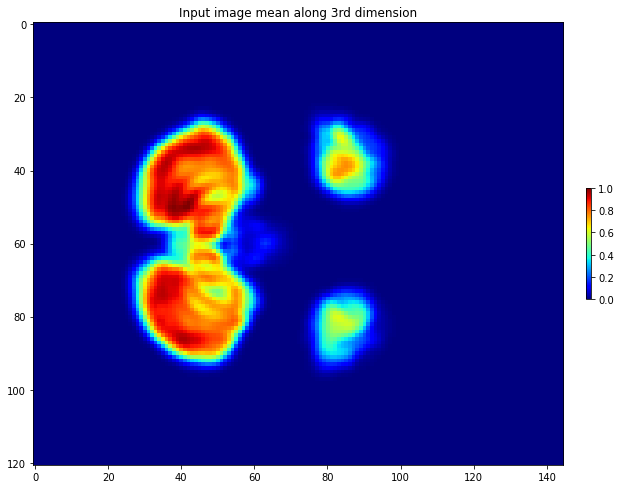

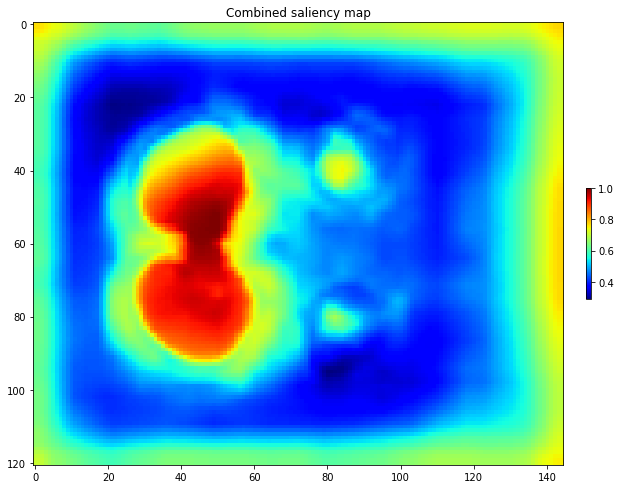

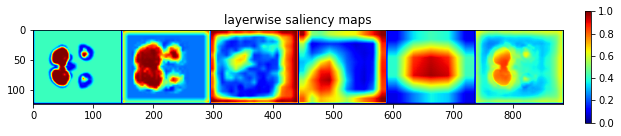

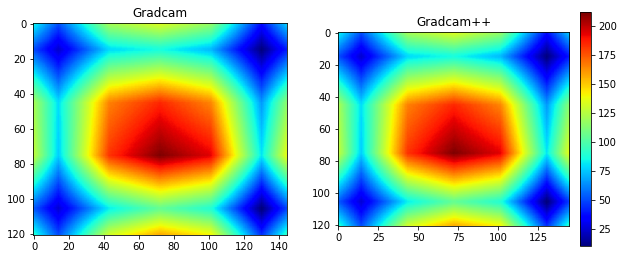

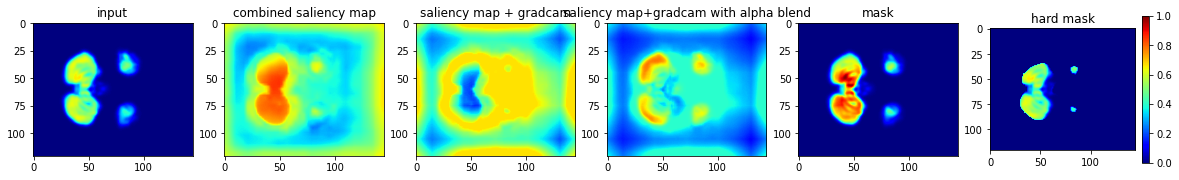

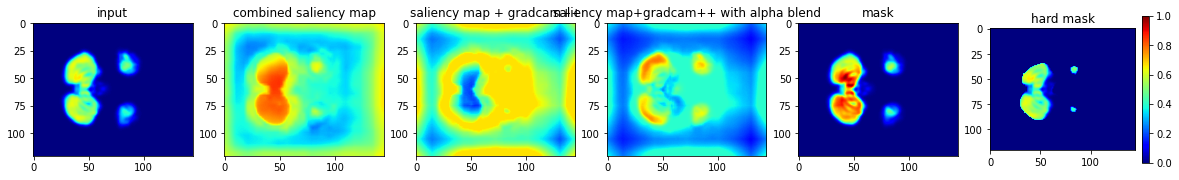

In [3]:
import yaml
if __name__=='__main__':
  print(tf.__version__)
  # total_gpus=tf.config.experimental.list_physical_devices('GPU')
  # print(f'total_gpus={total_gpus}')
  # gpu=total_gpus[2]
  # tf.config.experimental.set_visible_devices(gpu,'GPU')
  # tf.config.experimental.set_memory_growth(gpu, True)

  # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
  # print(f'GPUs used = {logical_gpus}')
  # parser = argparse.ArgumentParser(description='BioAgeNet training')
  # arguments = parser.parse_args()

  # arguments.config_path = "config/config_Age_3D.yml"
  # with open(arguments.config_path, 'r') as ymlfile:
  #       cf = yaml.load(ymlfile)
  
  # if not os.path.exists(base_dir_mat):
  #   os.makedirs(base_dir_mat)/model
  cf={'Pretrained_Model':{'path':'/content/drive/My Drive/BA_Estimation/models/exp2/age_net_oasis1_3.hdf5'},'Paths':\
      {'labels':'/content/drive/My Drive/BA_Estimation/csv_data/oasis1_oasis3_labels.csv',\
       'test_tfrecord':'/content/drive/My Drive/BA_Estimation/tf_records_data/testing_exp2'}}#testing_all_cdr
  model =  tf.python.keras.models.load_model(cf['Pretrained_Model']['path'],compile=False)
  tf_model = model
  tfw=tf_model.weights

  dt_string = datetime.now().strftime('%d-%m-%Y-%H-%M')+'_smoe_maps_blockend_scale_endlayers_equal_weights_cdr0training_log10_maps'
  # dt_string= '14-08-2020-14-50_smoe_maps_blockend_scale_endlayers_equal_weights_exp2.2'
  # dt_string = '07-08-2020-08-11'+'_smoe_maps_blockend_scale_endlayers_equal_weights'
  # dt_string = '03-08-2020-16-49'#datetime.now().strftime('%d-%m-%Y-%H-%M')

  label_path= cf['Paths']['labels'] #'/content/drive/My Drive/BA_Estimation/csv_data/oasis1_oasis3_labels.csv'#/media/shashanks/My Passport/documents/Master_Thesis_Backup/data/
  data_path= cf['Paths']['test_tfrecord'] #'/home/raarmak1/.shashanks/BA_estimation/tfrecords_data/OASIS1_3_combined/tfrecords_data_exp3/testing/'
  exp='exp2'
  # debug_mode_subject= ['OAS31054']#
  debug_mode_subject = ['OAS30884','OAS30720','OAS30344','OAS30541'] #,'OAS31054'] #OAS30911
  # debug_mode_subject=None
  test_patients,scan_ids, test_labels,test_gender,test_cdr = get_test_files(label_path,data_path,debug_mode_subject)
  tfr=tf.data.TFRecordDataset(test_patients)
  img_tf=tfr.map(map_func=lambda a:parse_function_image(a))
  # final_model.eval()
  # final_model.load_state_dict(inflated_model_dict)
  gender_dict={0:'Female',1:'Male'}
  for i,im in enumerate(img_tf): #OAS30686_d0030
    print(type(im),im.shape)
    img=im.numpy()
    print(img.shape)
    # if  'OAS30344'in scan_ids[i] or 'OAS30884' in scan_ids[i]  or 'OAS30911' in scan_ids[i]:
    # if 'OAS30884' in scan_ids[i] :# OAS30720 or 'OAS30884' in scan_ids[i] : #  OAS30911_MR_d0099
    max_intensity=0
    csmap_list=[]
    for chunk_id in [3,7,9,11,14,18]:#range(1,21):

      start = (chunk_id-1)*6
      end = chunk_id*6
      
      img_chunk=torch.tensor(img[:,:,start:end])
      # img_chunk=torch.tensor(img[:,:,0:6])
      img_chunk = img_chunk.unsqueeze(0)
      input_tensor = img_chunk.unsqueeze(0)
      # imshow(input_tensor[0,0,:,:,-1],cmap='jet')
      in_height   = input_tensor.size()[2]
      in_width    = input_tensor.size()[3]
      print(test_gender[i],input_tensor.shape,scan_ids[i])
      # break
      n=66
      # layer_name='conv3d_'+str(n-1)
      layer_name='activation_'+str(n-1)
      # conv_path ='conv1_'+str(n)+'_tfw'
      # conv_path ='conv1_'+str(n)+'_blockend_scale_endlayers_equal_weights'
      conv_path ='conv1_'+str(n)
      

      #axial
      base_dir= '/content/drive/My Drive/BA_Estimation/results/sal_map_axial/'+dt_string\
      +'_'+exp+'/'+scan_ids[i]+'_cdr'+str(test_cdr[i])
      path = base_dir+'/'+str(chunk_id)+'_'+conv_path+'/'
      print(path)
      if not os.path.exists(path):
        os.makedirs(path)
      base_path  = path+scan_ids[i]+'_chunk_'+str(chunk_id)
      csmap_a=compute_saliency_tf(base_path,inputs=[img[:,:,start:end],test_gender[i]],tf_model=tf_model,layer_end=n)
      image,gcam_img,gcam_pp_img = compute_gcam_and_gcam_pp(layer_name,tf_model,[img[:,:,start:end],test_gender[i]])
      combine_sal_gcam(path+scan_ids[i]+'_cdr'+str(test_cdr[i])+'_'+gender_dict[test_gender[i]],csmap_a,gcam_img,gcam_pp_img,image,layer_name=layer_name ) 
      
      break

      #sagittal
      base_dir= '/content/drive/My Drive/BA_Estimation/results/sal_map_sagittal/'+dt_string\
      +'_'+exp+'/'+scan_ids[i]+'_cdr'+str(test_cdr[i])
      path = base_dir+'/'+str(chunk_id)+'_'+conv_path+'/'
      print(path)
      if not os.path.exists(path):
        os.makedirs(path)
      base_path  = path+scan_ids[i]+'_chunk_'+str(chunk_id)
      img_s= torch.from_numpy(img[start:end,:,:]).permute(2,1,0)
      csmap_s=compute_saliency_tf(base_path,inputs=[img_s.numpy(),test_gender[i]],tf_model=tf_model,layer_end=n)
      image,gcam_img,gcam_pp_img = compute_gcam_and_gcam_pp(layer_name,tf_model,[img_s.numpy(),test_gender[i]])
      combine_sal_gcam(path+scan_ids[i]+'_cdr'+str(test_cdr[i])+'_'+gender_dict[test_gender[i]],csmap_s,gcam_img,gcam_pp_img,image,layer_name=layer_name ) 

      #coronal
      base_dir= '/content/drive/My Drive/BA_Estimation/results/sal_map_coronal/'+dt_string\
      +'_'+exp+'/'+scan_ids[i]+'_cdr'+str(test_cdr[i])
      path = base_dir+'/'+str(chunk_id)+'_'+conv_path+'/'
      print(path)
      if not os.path.exists(path):
        os.makedirs(path)
      base_path  = path+scan_ids[i]+'_chunk_'+str(chunk_id)
      img_c= torch.from_numpy(img[:,start:end,:]).permute(2,0,1)
      img_c=img_c.unsqueeze(0)
      img_c = torch.nn.functional.upsample(img_c.unsqueeze(0), size=(121,145,6), mode='nearest') 
      csmap_c=compute_saliency_tf(base_path,inputs=[img_c.numpy(),test_gender[i]],tf_model=tf_model,layer_end=n)
      image,gcam_img,gcam_pp_img = compute_gcam_and_gcam_pp(layer_name,tf_model,[img_c.numpy(),test_gender[i]])
      combine_sal_gcam(path+scan_ids[i]+'_cdr'+str(test_cdr[i])+'_'+gender_dict[test_gender[i]],csmap_c,gcam_img,gcam_pp_img,image,layer_name=layer_name ) 
    break  

    


In [ ]:
layers=[l.name for l in model.layers]
lout=[]
for i,l in enumerate(layers):
  if l.startswith('activation'):
    lout.append(l)
for i,l in enumerate(lout):
  print(i,l)

0 activation
1 activation_1
2 activation_2
3 activation_4
4 activation_6
5 activation_3
6 activation_5
7 activation_7
8 activation_8
9 activation_10
10 activation_12
11 activation_9
12 activation_11
13 activation_13
14 activation_14
15 activation_15
16 activation_16
17 activation_17
18 activation_19
19 activation_21
20 activation_18
21 activation_20
22 activation_22
23 activation_23
24 activation_25
25 activation_27
26 activation_24
27 activation_26
28 activation_28
29 activation_29
30 activation_30
31 activation_31
32 activation_32
33 activation_34
34 activation_36
35 activation_33
36 activation_35
37 activation_37
38 activation_38
39 activation_40
40 activation_42
41 activation_39
42 activation_41
43 activation_43
44 activation_44
45 activation_45
46 activation_46
47 activation_47
48 activation_49
49 activation_51
50 activation_48
51 activation_50
52 activation_52
53 activation_53
54 activation_55
55 activation_57
56 activation_54
57 activation_56
58 activation_58
59 activation_59
60

In [ ]:
dt_string

'14-08-2020-14-50_smoe_maps_blockend_scale_endlayers_equal_weights'

In [ ]:
model.summary() # 0,2,17,47,62

Model: "BioAgeNet_Regression"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 121, 145, 6, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 61, 73, 6, 64 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 61, 73, 6, 64 192         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 61, 73, 6, 64 0           batch_normalization[0][0]        
_______________________________________________________________________________

In [ ]:
layers

In [ ]:
!pip install innvestigate

In [ ]:
cf={'Pretrained_Model':{'path':'/content/drive/My Drive/BA_Estimation/models/exp2/age_net_oasis1_3.hdf5'},'Paths':\
      {'labels':'/content/drive/My Drive/BA_Estimation/csv_data/oasis1_oasis3_labels.csv',\
       'test_tfrecord':'/content/drive/My Drive/BA_Estimation/tf_records_data/testing_exp2'}}#testing_all_cdr
model =  tf.python.keras.models.load_model(cf['Pretrained_Model']['path'],compile=False)

In [ ]:
import innvestigate
analyzer = innvestigate.create_analyzer("lrp.flat", model) #,kwargs={'rule':'BoundedRule'})
# dir(analyzer)

/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f5cb5775400>, <tensorflow.python.keras.layers.convolutional.Conv3D object at 0x7f5cb57a71d0>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f5cb57a7710>, <tensorflow.python.keras.layers.core.Activation object at 0x7f5cb57a79e8>, <tensorflow.python.keras.layers.pooling.MaxPooling3D object at 0x7f5cb57a7ba8>, <tensorflow.python.keras.layers.convolutional.Conv3D object at 0x7f5cb57a7dd8>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f5cb4f68128>, <tensorflow.python.keras.layers.core.Activation object at 0x7f5cb4f68400>, <tensorflow.python.keras.layers.convolutional.Conv3D object at 0x7f5cb4f685c0>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f5cb4f688

In [ ]:
label_path= cf['Paths']['labels'] #'/content/drive/My Drive/BA_Estimation/csv_data/oasis1_oasis3_labels.csv'#/media/shashanks/My Passport/documents/Master_Thesis_Backup/data/
data_path= cf['Paths']['test_tfrecord'] #'/home/raarmak1/.shashanks/BA_estimation/tfrecords_data/OASIS1_3_combined/tfrecords_data_exp3/testing/'
exp='exp2'
debug_mode_subject= ['OAS30884']#
# debug_mode_subject = ['OAS30884','OAS30720','OAS30344','OAS30541'] #OAS30911
# debug_mode_subject=None
test_patients,scan_ids, test_labels,test_gender,test_cdr = get_test_files(label_path,data_path,debug_mode_subject)
tfr=tf.data.TFRecordDataset(test_patients)
img_tf=tfr.map(map_func=lambda a:parse_function_image(a))
# final_model.eval()
# final_model.load_state_dict(inflated_model_dict)
gender_dict={0:'Female',1:'Male'}
for i,im in enumerate(img_tf): #OAS30686_d0030
  print(type(im),im.shape)
  img=im.numpy()
  print(img.shape)
  # if  'OAS30344'in scan_ids[i] or 'OAS30884' in scan_ids[i]  or 'OAS30911' in scan_ids[i]:
  # if 'OAS30884' in scan_ids[i] :# OAS30720 or 'OAS30884' in scan_ids[i] : #  OAS30911_MR_d0099
  max_intensity=0
  csmap_list=[]
  for chunk_id in [7,9,11,14,18]:#range(1,21):

    start = (chunk_id-1)*6
    end = chunk_id*6
    
    img_chunk=torch.tensor(img[:,:,start:end])
    img_chunk = img_chunk.unsqueeze(0).numpy()
    break

<class 'tensorflow.python.framework.ops.EagerTensor'> (121, 145, 121)
(121, 145, 121)
<class 'tensorflow.python.framework.ops.EagerTensor'> (121, 145, 121)
(121, 145, 121)
<class 'tensorflow.python.framework.ops.EagerTensor'> (121, 145, 121)
(121, 145, 121)


In [ ]:
img_chunk.shape

(1, 121, 145, 6)

In [ ]:
analysis = analyzer.analyze(img_chunk)

AttributeError: ignored

In [ ]:
model.summary()

Model: "BioAgeNet_Regression"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 121, 145, 6, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 61, 73, 6, 64 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 61, 73, 6, 64 192         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 61, 73, 6, 64 0           batch_normalization[0][0]        
_______________________________________________________________________________

In [ ]:
dt_string

In [ ]:
model.summary()

Model: "BioAgeNet_CDR_classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 121, 145, 6, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 61, 73, 6, 64 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 61, 73, 6, 64 192         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 61, 73, 6, 64 0           batch_normalization[0][0]        
_______________________________________________________________________

In [ ]:
for l in model.layers:
  print(l.name)

input_1
conv3d
batch_normalization
activation
MaxPool2d_2a_3x3
conv3d_1
batch_normalization_1
activation_1
conv3d_2
batch_normalization_2
activation_2
MaxPool2d_3a_3x3
conv3d_4
conv3d_6
batch_normalization_4
batch_normalization_6
activation_4
activation_6
max_pooling3d
conv3d_3
conv3d_5
conv3d_7
conv3d_8
batch_normalization_3
batch_normalization_5
batch_normalization_7
batch_normalization_8
activation_3
activation_5
activation_7
activation_8
Mixed_3b
conv3d_10
conv3d_12
batch_normalization_10
batch_normalization_12
activation_10
activation_12
max_pooling3d_1
conv3d_9
conv3d_11
conv3d_13
conv3d_14
batch_normalization_9
batch_normalization_11
batch_normalization_13
batch_normalization_14
activation_9
activation_11
activation_13
activation_14
Mixed_3c
max_pooling3d_2
conv3d_16
conv3d_18
batch_normalization_16
batch_normalization_18
activation_16
activation_18
max_pooling3d_3
conv3d_15
conv3d_17
conv3d_19
conv3d_20
batch_normalization_15
batch_normalization_17
batch_normalization_19
batch_

In [ ]:
[i for i in range(65,0,-1)]

[65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1]